![logo](img/spotify_recommender_logo.png)

# Spotify Songs Recommender

In [122]:
# scraping libraries
from bs4 import BeautifulSoup
import requests

# spotipy = spotify API wrapper
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# standard libraries
import pandas as pd
import numpy as np
import math
from collections import defaultdict

# for drawing progress bars
from tqdm.notebook import tqdm

# for dealing with passwords and user names
import getpass

# machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Scraping

Specify Spotify credentials to interact with API

These can be found in the file secrets 

In [2]:
# spotify client id
client_id = getpass.getpass(prompt='input client_id') 

# spotify password or 'secret'
client_secret = getpass.getpass(prompt='input client_secret')

input client_id········
input client_secret········


In [3]:
# instantiate spotipy object using client id and secret
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))

Get "The Hot 100" Billboard Songs

In [4]:
# specify url where the top 100 songs chart is
url = "https://www.billboard.com/charts/hot-100"

In [13]:
# get url response
response = requests.get(url)

# if the status code is 200 then parse the webpage
if response.status_code == 200:

    # soup contains the webpage
    soup = BeautifulSoup(response.content, 'html.parser')
    print('status code : 200 --> html parsed')

# if the request wasn't successful then print
else:
    print('get request unsuccessful')

status code : 200 --> html parsed


In [16]:
# build a dataframe showing name of the song and artist

titles = []
artists = []

# get all the titles and append to list
for tag in soup.find_all('span', 'chart-element__information__song text--truncate color--primary'):
    titles.append(tag.get_text())

# get all the artists and append to list
for tag in soup.find_all('span', 'chart-element__information__artist text--truncate color--secondary'):
    artists.append(tag.get_text())

# create dataframe with the two columns
top100 = pd.DataFrame({'title':titles, 'artist':artists})

# show first 10
top100.head(10)

,title,artist
0,What's Next,Drake
1,Wants And Needs,Drake Featuring Lil Baby
2,Lemon Pepper Freestyle,Drake Featuring Rick Ross
3,Leave The Door Open,Silk Sonic (Bruno Mars & Anderson .Paak)
4,Drivers License,Olivia Rodrigo
5,Up,Cardi B
6,Save Your Tears,The Weeknd
7,Blinding Lights,The Weeknd
8,34+35,Ariana Grande
9,Mood,24kGoldn Featuring iann dior


In [19]:
# check that there are 100 titles and artists
top100.shape

(100, 2)

Get many songs from Spotify

We'll get all the songs that are into a playlist whose creator is Spotify

In [27]:
# specify creator of the playlists
user = 'spotify'

# pass user to our spotipy object and get all the playlists
playlists = sp.user_playlists(user)

In [29]:
# we need the names of the playlists and their URI (uniform resource identifier)
playlist_uri = []
playlist_names = []

while playlists:

    # iterate over the playlists' items
    for playlist in playlists['items']:
    
        # get URI and append to list
        playlist_uri.append(playlist['uri'])
        
        # get name of the playlist and append to list
        playlist_names.append(playlist['name'])
        
    # deal with paged results
    if playlists['next']:
        
        # turns the page
        playlists = sp.next(playlists)
        
    else:
        
        # empties the list of playlists
        playlists = None

In [31]:
# show results using a dataframe
pd.DataFrame({'playlist_name':playlist_names, 'playlist_uri':playlist_uri})

,playlist_name,playlist_uri
0,Today's Top Hits,spotify:playlist:37i9dQZF1DXcBWIGoYBM5M
1,RapCaviar,spotify:playlist:37i9dQZF1DX0XUsuxWHRQd
2,Hot Country,spotify:playlist:37i9dQZF1DX1lVhptIYRda
3,¡Viva Latino!,spotify:playlist:37i9dQZF1DX10zKzsJ2jva
4,New Music Friday,spotify:playlist:37i9dQZF1DX4JAvHpjipBk
...,...,...
1393,Women of Pop,spotify:playlist:37i9dQZF1DX3WvGXE8FqYX
1394,dw-c,spotify:playlist:5ji4GZJpll6twskFvKxiHx
1395,dw_g,spotify:playlist:40VxbK9NqccdUDUpiUXmbp
1396,Top Shower Songs,spotify:playlist:0RTz1jFo5BXGPfI8eVf8sj


In [40]:
def get_tracks_from_playlist(username, playlist_id):
    """
    Signature: get_tracks_from_playlist(username: str, playlist_id: str) -> dict
    
    Docstring:
    Returns song id, name and artist for each track contained in a Spotify playlist
    
    Parameters
    ----------
    username : str
        Creator of the playlist
    playlist_id : str
        URI of the playlist
    """

    # lists for song id, name and artists
    s_id = []
    s_name = []
    s_artists = []

    # get all the songs and keep the items
    results = sp.user_playlist_tracks(username, playlist_id)
    items = results['items']
    
    # deal with paged results
    while results['next']:
        results = sp.next(results)
        items.extend(results['items'])
    
    # iterate over all the items
    for i in items:

        # if the track isn't empty
        if i['track'] != None:
            
            # append the song id, in case it's empty write "missing value"
            s_id.append("missing value" if i['track']['id'] == None else i['track']['id'])
            
            # append the title of the song
            s_name.append(i['track']['name'])
            
            # append the name of the artists
            s_artists.append([j['name'] for j in i['track']['artists']])

    # create a dictionary with song id, name and artists
    d = {'song_id':s_id, 'song_name':s_name, 'artists':s_artists}
    
    return d

In [41]:
# all the songs from all the playlists will be collected into the dictionary 'songs'
# this process can take a while due to the high amount of songs
songs = {'song_id':[], 'song_name':[], 'artists':[]}

# iterate over the list of Spotify' playlists
for i in tqdm(playlist_uri):
    
    # get all the songs for every playlist
    d = get_tracks_from_playlist("", i)
    
    # append every song id, name and artists for each song contained in the playlist
    # to the dictionary 'songs'
    [songs['song_id'].append(i) for i in d['song_id']]
    [songs['song_name'].append(i) for i in d['song_name']]
    [songs['artists'].append(i) for i in d['artists']]

  0%|          | 0/1398 [00:00<?, ?it/s]

In [42]:
# store the songs into a dataframe
df_songs = pd.DataFrame(songs)

# show the first 10
df_songs.head(10)

,song_id,song_name,artists
0,4MmMxyew8yq1OEyJOMaX6M,As I Am,"[Justin Bieber, Khalid]"
1,5QO79kh1waicV47BqGRL3g,Save Your Tears,[The Weeknd]
2,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,[Masked Wolf]
3,1diS6nkxMQc3wwC4G1j0bh,We're Good,[Dua Lipa]
4,7MAibcTli4IisCtbHKrGMh,Leave The Door Open,"[Bruno Mars, Anderson .Paak, Silk Sonic]"
5,4iJyoBOLtHqaGxP12qzhQI,Peaches,"[Justin Bieber, Daniel Caesar, Giveon]"
6,1XXimziG1uhM0eDNCZCrUl,Up,[Cardi B]
7,5uEYRdEIh9Bo4fpjDd4Na9,Goosebumps - Remix,"[Travis Scott, HVME]"
8,6tDDoYIxWvMLTdKpjFkc1B,telepatía,[Kali Uchis]
9,463CkQjx2Zk1yXoBuierM9,Levitating (feat. DaBaby),"[Dua Lipa, DaBaby]"


In [249]:
# how many songs do we have?
df_songs.shape

(82487, 3)

Remove the duplicates

In [250]:
# because a song can exist in more than one playlist, several duplicates will be found
# show how many
df_songs.duplicated(subset='song_id').sum()

0

In [251]:
# delete all the duplicated songs
df_songs = df_songs.drop_duplicates(subset='song_id').reset_index(drop=True)

# check how many songs are left
df_songs.shape

(82487, 3)

## Audio Features

Now we want the sound features for each song

This process is slow, but the fastest way of doing it is by requesting 100 songs at a time

In [55]:
math.ceil(df_songs.shape[0]/100)

825

In [58]:
features_list = []

# how many lists of 100 songs do we need to cover all the songs?
# we divide the amount of songs by 100 and round it up 
n = math.ceil(df_songs.shape[0]/100)

# iterate over the amount of lists needed
for i in tqdm(range(n)):
    
    # create a list with the 100 song ids corresponding to every iteration
    l = df_songs['song_id'].to_list()[i*100:(i+1)*100]
    
    # get the audio features for these 100 songs
    f = sp.audio_features(l)
    
    # append to the features_list if not empty
    # append None if empty
    [(features_list.append(j) if j != None else None) for j in f]

  0%|          | 0/825 [00:00<?, ?it/s]

In [64]:
# create a dataframe with all the audio features

# first create a default dictionary
dic = defaultdict(list)

# and store every feature on the features list
{dic[key].append(f[key]) for f in features_list for key in f}

# now create the dataframe using the dictionary of features
df_features = pd.DataFrame(dict(dic))

# show the first 10
df_features.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.608,0.505,8,-8.190,0,0.0371,0.12300,0.000000,0.0955,0.115,99.997,audio_features,4MmMxyew8yq1OEyJOMaX6M,spotify:track:4MmMxyew8yq1OEyJOMaX6M,https://api.spotify.com/v1/tracks/4MmMxyew8yq1...,https://api.spotify.com/v1/audio-analysis/4MmM...,174406,4
1,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,audio_features,5QO79kh1waicV47BqGRL3g,spotify:track:5QO79kh1waicV47BqGRL3g,https://api.spotify.com/v1/tracks/5QO79kh1waic...,https://api.spotify.com/v1/audio-analysis/5QO7...,215627,4
2,0.778,0.695,4,-6.865,0,0.0913,0.17500,0.000000,0.1500,0.472,149.996,audio_features,3Ofmpyhv5UAQ70mENzB277,spotify:track:3Ofmpyhv5UAQ70mENzB277,https://api.spotify.com/v1/tracks/3Ofmpyhv5UAQ...,https://api.spotify.com/v1/audio-analysis/3Ofm...,132780,4
3,0.722,0.588,6,-5.932,1,0.0544,0.03190,0.000000,0.1830,0.590,134.010,audio_features,1diS6nkxMQc3wwC4G1j0bh,spotify:track:1diS6nkxMQc3wwC4G1j0bh,https://api.spotify.com/v1/tracks/1diS6nkxMQc3...,https://api.spotify.com/v1/audio-analysis/1diS...,165507,4
4,0.586,0.616,5,-7.964,1,0.0324,0.18200,0.000000,0.0927,0.719,148.088,audio_features,7MAibcTli4IisCtbHKrGMh,spotify:track:7MAibcTli4IisCtbHKrGMh,https://api.spotify.com/v1/tracks/7MAibcTli4Ii...,https://api.spotify.com/v1/audio-analysis/7MAi...,242096,4
5,0.634,0.679,0,-6.176,1,0.1780,0.37500,0.000000,0.4240,0.488,89.938,audio_features,4iJyoBOLtHqaGxP12qzhQI,spotify:track:4iJyoBOLtHqaGxP12qzhQI,https://api.spotify.com/v1/tracks/4iJyoBOLtHqa...,https://api.spotify.com/v1/audio-analysis/4iJy...,198082,4
6,0.868,0.795,11,-6.044,1,0.2690,0.00120,0.019300,0.0461,0.819,166.000,audio_features,1XXimziG1uhM0eDNCZCrUl,spotify:track:1XXimziG1uhM0eDNCZCrUl,https://api.spotify.com/v1/tracks/1XXimziG1uhM...,https://api.spotify.com/v1/audio-analysis/1XXi...,156945,4
7,0.841,0.593,1,-7.846,1,0.0379,0.41800,0.000000,0.1240,0.808,124.917,audio_features,5uEYRdEIh9Bo4fpjDd4Na9,spotify:track:5uEYRdEIh9Bo4fpjDd4Na9,https://api.spotify.com/v1/tracks/5uEYRdEIh9Bo...,https://api.spotify.com/v1/audio-analysis/5uEY...,162803,4
8,0.653,0.524,11,-9.016,0,0.0502,0.11200,0.000000,0.2030,0.553,83.970,audio_features,6tDDoYIxWvMLTdKpjFkc1B,spotify:track:6tDDoYIxWvMLTdKpjFkc1B,https://api.spotify.com/v1/tracks/6tDDoYIxWvML...,https://api.spotify.com/v1/audio-analysis/6tDD...,160191,4
9,0.702,0.825,6,-3.787,0,0.0601,0.00883,0.000000,0.0674,0.915,102.977,audio_features,463CkQjx2Zk1yXoBuierM9,spotify:track:463CkQjx2Zk1yXoBuierM9,https://api.spotify.com/v1/tracks/463CkQjx2Zk1...,https://api.spotify.com/v1/audio-analysis/463C...,203064,4


In [72]:
# the number of songs is different from the number of audio features
# that's because Spotify doesn't have the audio feature for all the songs
print('number of songs is: ' + str(df_songs.shape[0]))
print('number of audio features is: ' + str(df_features.shape[0]))

number of songs is: 82487
number of audio features is: 82375


In [252]:
# filter the songs that have a very high 'speechiness'
# i.e. those that are narrations
df_features = df_features[df_features['speechiness']<0.6]

In [253]:
# create a new dataframe combining df_songs and df_features
# renaming the columns so that they match
df_all = df_songs.merge(df_features.rename({'id':'song_id'}, axis=1), on='song_id', how='right')

# check the names of the columns
df_all.columns

Index(['song_id', 'song_name', 'artists', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [254]:
# drop useless and duplicated information
df_all = df_all.drop(['type', 'uri', 'track_href', 'analysis_url'], axis=1)

In [259]:
# check how many songs left
df_all.shape

(75995, 16)

In [260]:
# show the first rows
df_all.head()

,song_id,song_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,4MmMxyew8yq1OEyJOMaX6M,As I Am,"[Justin Bieber, Khalid]",0.608,0.505,8,-8.190,0,0.0371,0.1230,0.000000,0.0955,0.115,99.997,174406,4
1,5QO79kh1waicV47BqGRL3g,Save Your Tears,[The Weeknd],0.680,0.826,0,-5.487,1,0.0309,0.0212,0.000012,0.5430,0.644,118.051,215627,4
2,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,[Masked Wolf],0.778,0.695,4,-6.865,0,0.0913,0.1750,0.000000,0.1500,0.472,149.996,132780,4
3,1diS6nkxMQc3wwC4G1j0bh,We're Good,[Dua Lipa],0.722,0.588,6,-5.932,1,0.0544,0.0319,0.000000,0.1830,0.590,134.010,165507,4
4,7MAibcTli4IisCtbHKrGMh,Leave The Door Open,"[Bruno Mars, Anderson .Paak, Silk Sonic]",0.586,0.616,5,-7.964,1,0.0324,0.1820,0.000000,0.0927,0.719,148.088,242096,4


Feature selection

In [261]:
# pick the continuous variables that we consider important for clustering
X_cont = df_all[[
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms'
]]

In [262]:
# now pick the discrete variables
X_disc = df_all[[
    'key',
    'mode',
    'time_signature'
]]

## Pre-processing

Standardize the continuous variables

In [263]:
# instantiate standard scaler
scaler = StandardScaler()

# fit transform the continuous variables
X_cont_st = scaler.fit_transform(X_cont)

# create a dataframe with them using the original column names
X_cont_st = pd.DataFrame(X_cont_st, columns=X_cont.columns)

No need to encode the discrete variables

In [264]:
# change the dtypes to object
X_disc = X_disc.astype('object')

Join all features

In [265]:
# concatenate the preprocessed variables
X_prep = pd.concat([X_cont_st, X_disc], axis=1)

# show the first rows
X_prep.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key,mode,time_signature
0,0.386926,-0.131844,0.339519,-0.474154,-0.710368,-0.602982,-0.561517,-1.199270,-0.548998,-0.443606,8,0,4
1,0.763194,0.976773,0.724541,-0.543906,-0.986104,-0.602947,2.297228,0.819274,0.017241,-0.154953,0,1,4
2,1.275337,0.524347,0.528255,0.135608,-0.569521,-0.602982,-0.213357,0.162961,1.019154,-0.735094,4,0,4
3,0.982684,0.154808,0.661154,-0.279525,-0.957122,-0.602982,-0.002544,0.613222,0.517774,-0.505922,6,1,4
4,0.271955,0.251510,0.371711,-0.527030,-0.550561,-0.602982,-0.579404,1.105457,0.959312,0.030398,5,1,4


## Clustering

Elbow Method

In [ ]:
# we need to find out what is the optimal number of clusters for this dataset
# let's try the elbow method with KMeans

# try from 2 to 20 clusters
K = range(2,20)

inertias = []

# create a KMeans for every number of clusters possible (inside the range K)
# calculate inertia for every one of them and append the values to the list inertias
for k in tqdm(K):
    
    # instantiate KMeans
    kmeans = KMeans(
        n_clusters=k,
        random_state=1234
    )
    
    # train the model
    kmeans.fit(X_prep)
    
    # calculate inertias and append
    inertias.append(kmeans.inertia_)

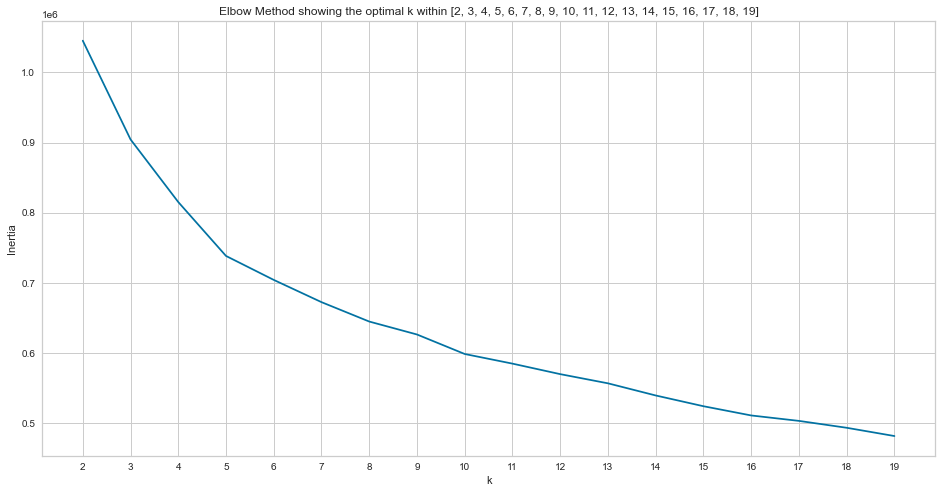

In [99]:
# plot inertias for every k

plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Elbow Method showing the optimal k within {list(K)}')
plt.show()

Silhouette Scores

In [100]:
# let's try the silhouette scores instead (careful: very lengthy process)

# using the same range as before (from 2 to 20)
K = range(2,20)

silhouettes = []

# create a KMeans for every number of clusters possible (inside the range K)
# calculate silhouette score for every one of them and append the values to the list silhouettes
for k in tqdm(K):

    # instantiate KMeans
    kmeans = KMeans(
        n_clusters=k,
        random_state=1234
    )
    
    # train the model
    kmeans.fit(X_prep)
    
    # calculate silhouette score
    s = silhouette_score(X_prep, kmeans.predict(X_prep))
    
    # append score to list
    silhouettes.append(s)
    

  0%|          | 0/18 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Silhouette Method showing the optimal k within [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]')

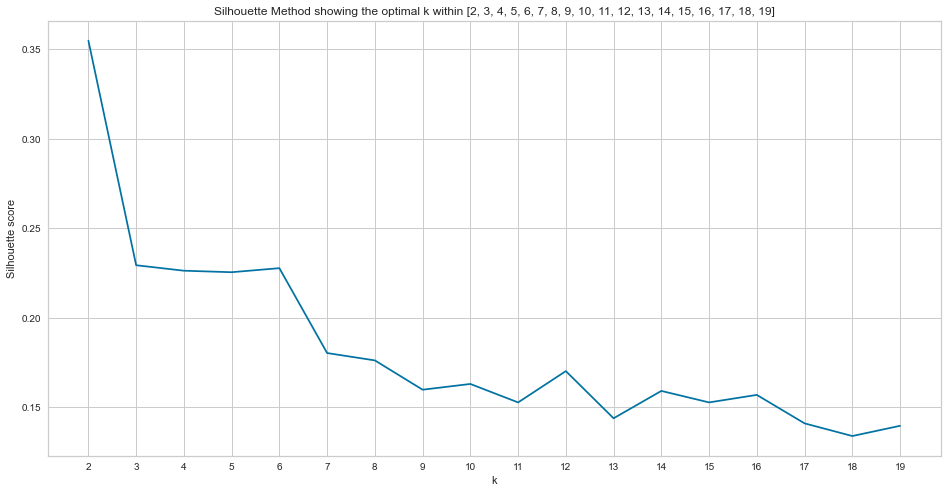

In [102]:
# plot silhouette scores for every k

plt.figure(figsize=(16,8))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Silhouette Method showing the optimal k within {list(K)}')

Silhouette Visualizer

  0%|          | 0/6 [00:00<?, ?it/s]

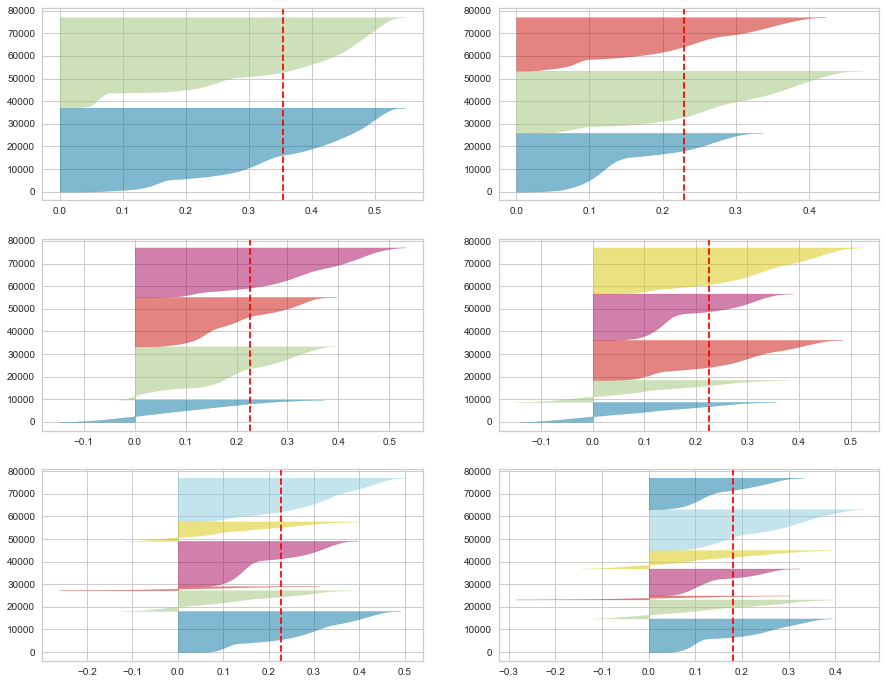

In [108]:
# from 2 to 7 clusters
K = range(2,8)

# subplots for all the silhouettes
fig, ax = plt.subplots(3, 2, figsize=(15,12))

for k in tqdm(K):
    
    # instantiate KMeans
    km = KMeans(
        n_clusters=k,
        random_state=1234
    )

    q, mod = divmod(k, 2)
    
    # instantiate the visualizer using the KMeans object
    visualizer = SilhouetteVisualizer(
        km,
        colors='yellowbrick',
        ax=ax[q-1][mod]
    )

    # fit the visualizer
    visualizer.fit(X_prep)

We decide for 6 clusters

In [266]:
# save the column names for later
cols = X_prep.columns

# instantiate KMeans for the selected number of clusters
kmeans = KMeans(
    n_clusters=6,
    random_state=1234
)

# train the model
kmeans.fit(X_prep)

# get the results and store them in 'clusters'
clusters = kmeans.predict(X_prep)

In [267]:
# create a dataframe including the clustering numbers

# first duplicate the pre-processed df
songs_clustered = X_prep.copy()

# and add a column for the cluster number which is in the array 'clusters'
songs_clustered['cluster_id'] = clusters

# convert all the columns to number type
songs_clustered = songs_clustered.astype(np.number)

# show the first rows
songs_clustered.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key,mode,time_signature,cluster_id
0,0.386926,-0.131844,0.339519,-0.474154,-0.710368,-0.602982,-0.561517,-1.199270,-0.548998,-0.443606,8.0,0.0,4.0,2.0
1,0.763194,0.976773,0.724541,-0.543906,-0.986104,-0.602947,2.297228,0.819274,0.017241,-0.154953,0.0,1.0,4.0,5.0
2,1.275337,0.524347,0.528255,0.135608,-0.569521,-0.602982,-0.213357,0.162961,1.019154,-0.735094,4.0,0.0,4.0,3.0
3,0.982684,0.154808,0.661154,-0.279525,-0.957122,-0.602982,-0.002544,0.613222,0.517774,-0.505922,6.0,1.0,4.0,2.0
4,0.271955,0.251510,0.371711,-0.527030,-0.550561,-0.602982,-0.579404,1.105457,0.959312,0.030398,5.0,1.0,4.0,3.0


In [268]:
# create a dataframe for the centroids
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=cols)

# add the cluster numbers
cluster_centers_df['cluster_id'] = range(0,6)

3D Plots

In [269]:
def plot_3d_clusters(df):
    """
    Signature: plot_3d_clusters(df: DataFrame)
    
    Docstring:
    Prints a 3D scatter plot to visualize clustering.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame with 4 columns. The first 3 are the variables chosen. The 4th the clustering.
    """

    cols = []

    # stores all the column names in the list 'cols'
    for i in range(df.shape[1]):
        cols.append(df.columns[i])

    # creates 3D plot
    plt.figure(figsize=(7,7))
    ax = plt.axes(projection = '3d')
    
    # adds the data using the first 3 columns for x, y and z
    # the 4th column defines the color
    ax.scatter(
        xs=df[cols[0]],
        ys=df[cols[1]],
        zs=df[cols[2]],
        c=df[cols[3]],
        cmap='Set2'
    )

    # adds the names of the variables to the axes
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    ax.set_zlabel(cols[2])

    # shows the plot
    plt.show()
    
    pass

In [270]:
# create some groupings for 3D plotting

# sub1 -> danceability, loudness and tempo
songs_clustered_3dsub1 = songs_clustered[['danceability', 'loudness', 'tempo', 'cluster_id']]

# sub2 -> speechiness, energy and key
songs_clustered_3dsub2 = songs_clustered[['speechiness', 'energy', 'key', 'cluster_id']]

# sub3 -> speechiness, energy and key
songs_clustered_3dsub3 = songs_clustered[['loudness', 'key', 'duration_ms', 'cluster_id']]

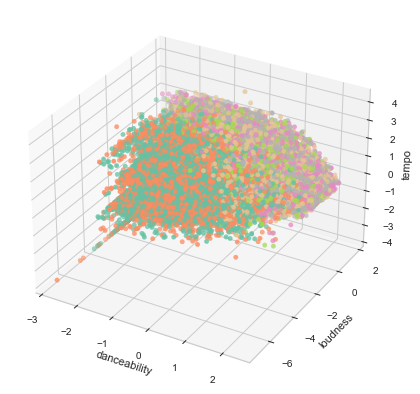

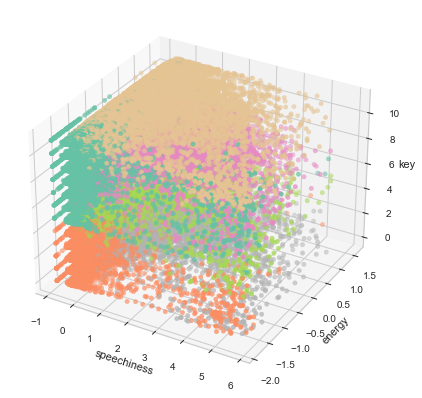

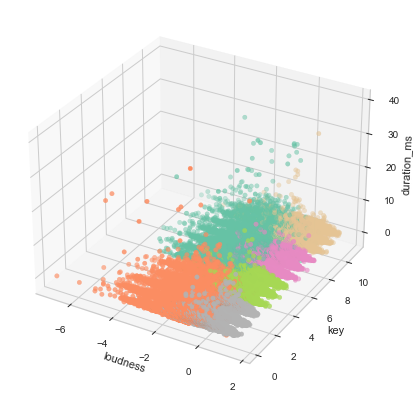

In [271]:
# plot everything
plot_3d_clusters(songs_clustered_3dsub1)
plot_3d_clusters(songs_clustered_3dsub2)
plot_3d_clusters(songs_clustered_3dsub3)

2D Plots with Centroids

In [272]:
def plot_2d_clusters(df, centers):
    """
    Signature: plot_2d_clusters(df: DataFrame, centers: Series)
    
    Docstring:
    Prints a 2D scatter plot to visualize clustering.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame with 3 columns. The first 2 are the variables chosen. The 3rd the clustering.
    centers: Series
        Coordinates for the centroids.
    """

    cols = []

    # stores all the column names in the list 'cols'
    for i in range(df.shape[1]):
        cols.append(df.columns[i])

    # plot datapoints
    sns.scatterplot(
        data=df,
        x=cols[0],
        y=cols[1],
        hue=cols[2],
    )

    # plot centroids
    sns.scatterplot(
        data=centers,
        x=cols[0],
        y=cols[1],
        hue=cols[2],
        legend=False,
        marker=u'8',
        s=500
    )

    # shows the plot
    plt.show()
    
    pass

In [274]:
# create some groupings for 2D plotting

# sub1 -> danceability and loudness
songs_clustered_2dsub1 = songs_clustered[['danceability', 'loudness', 'cluster_id']]
cluster_centers_2dsub1 = cluster_centers_df[['danceability', 'loudness', 'cluster_id']]

# sub2 -> instrumentalness and liveness
songs_clustered_2dsub2 = songs_clustered[['instrumentalness', 'liveness', 'cluster_id']]
cluster_centers_2dsub2 = cluster_centers_df[['instrumentalness', 'liveness', 'cluster_id']]

# sub3 -> tempo and key
songs_clustered_2dsub3 = songs_clustered[['tempo', 'key', 'cluster_id']]
cluster_centers_2dsub3 = cluster_centers_df[['tempo', 'key', 'cluster_id']]

# sub4 -> acousticness and energy
songs_clustered_2dsub4 = songs_clustered[['acousticness', 'energy', 'cluster_id']]
cluster_centers_2dsub4 = cluster_centers_df[['acousticness', 'energy', 'cluster_id']]

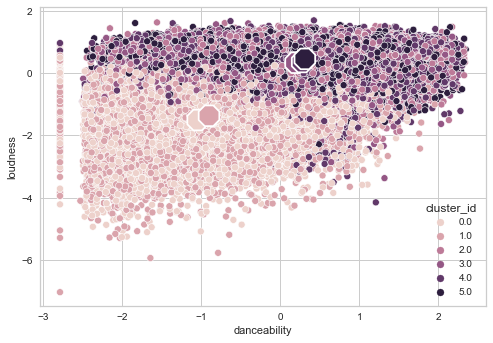

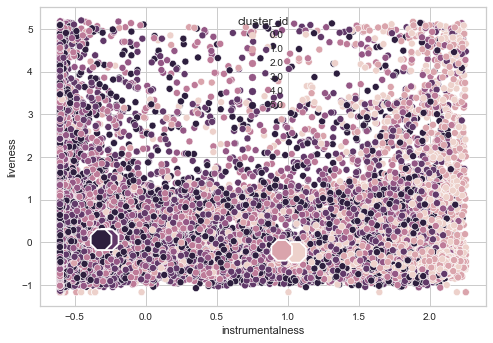

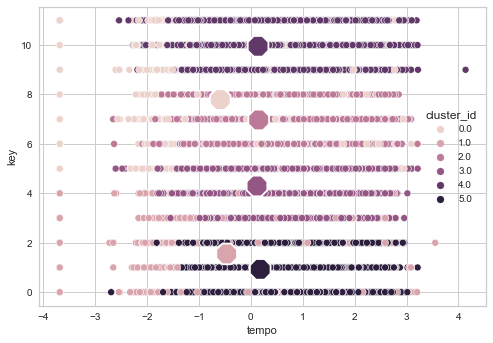

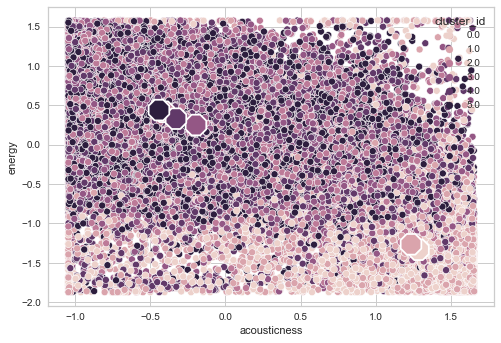

In [275]:
# plot everything
plot_2d_clusters(songs_clustered_2dsub1, cluster_centers_2dsub1)
plot_2d_clusters(songs_clustered_2dsub2, cluster_centers_2dsub2)
plot_2d_clusters(songs_clustered_2dsub3, cluster_centers_2dsub3)
plot_2d_clusters(songs_clustered_2dsub4, cluster_centers_2dsub4)

## Recommendation algorithm

Is a song in the Top 100 list?

In [276]:
def is_hot(song):
    """
    Signature: is_hot(song: str) -> bool
    
    Docstring:
    Returns True if the song is in the top 100 chart and False if it isn't.
    
    Parameters
    ----------
    song : str
        Song name. It can be only a fragment of the title.
    """

    # get all the songs from the top 100 chart that contain the string inside 'song'
    s = top100['title'].str.contains(song, na=False, case=False)
    
    # if there is at least one song with that string return True
    # if not return False
    if s.sum() > 0:
        return True
    else:
        return False

In [277]:
# test the is_hot function
is_hot('Drivers')

True

Ask for user input and recommend song

In [278]:
def recommend():
    """
    Signature: recommend()
    
    Docstring:
        Asks the user for a song title. If the song is in the top 100 chart, recommends another song
        from that same list. If it's not, recommends a song based on the audio features of the song inputted.
        It determines to which cluster the user's song belongs, and then recommends another from the
        same cluster.
    """

    # ask the user for a song
    print("""
    Enter your song's name. Example:
    >>> where is love?
    """)
    
    # store the inputted song
    user_input = input()
    
    # is the song in the top 100 chart?
    if is_hot(user_input):
        
        # if it is, then return the first match found
        s = top100[top100['title'].str.contains(user_input, na=False, case=False)].sample()
        print('Match found!')
        print('* ' + '"' + s.iloc[0]['title'] + '"' + ' by ' + s.iloc[0]['artist'])
        
        # and recommend a random song from inside the top 100 list
        s = top100.sample()
        print("""Your song is hot!\nHere's another one for you to check out:""")
        print('* ' + '"'+s.iloc[0]['title']+'"' + ' by ' + s.iloc[0]['artist'])
    
    # if the song is not in the top 100 chart        
    else:
    
        # search the song in the Spotify database
        result = sp.search(q=user_input, type='track', limit=1)
        
        # requests the audio features for the chosen song
        song_audio_features = sp.audio_features(result['tracks']['items'][0]['id'])
        
        # convert the result into a dataframe using the previously selected features as columns
        song_audio_features_df = pd.DataFrame(song_audio_features, columns=X_cont.columns)
        
        # scale transform the features
        song_scaled = pd.DataFrame(scaler.transform(song_audio_features_df))
        
        # discrete variables as we did before
        song_disc = pd.DataFrame(song_audio_features, columns=['key','mode','time_signature'])
        
        # concatenate everything
        song_audio_features = pd.concat([song_scaled,song_disc], axis=1)
        
        # use KMeans to find which cluster user's song belongs to
        cl = kmeans.predict(song_audio_features)[0]
        
        # pick a random song with the same cluster number
        recommendation = df_all.iloc[songs_clustered[songs_clustered.cluster_id==cl].sample().index]

        # print the match found
        print("""Your song is not in the Top 100.\nThis match was found:""")
        print("* " + str(result['tracks']['items'][0]['name']) +
              " by " +
              str(result['tracks']['items'][0]['artists'][0]['name']))
        
        # print recommended song and artists
        print("Here's another one for you to check out:")
        print('* ' + str(recommendation.song_name.iloc[0]) +
              " by "
              + str([i for i in recommendation.artists.iloc[0]][0]))
    pass

Execute

In [281]:
recommend()


    Enter your song's name. Example:
    >>> where is love?
    
por una cabeza
Your song is not in the Top 100.
This match was found:
* Por Una Cabeza by The Tango Project
Here's another one for you to check out:
* Goodbye Girl by David Gates
